In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
import numpy as np
import pymc3 as pm
import seaborn as sns

In [51]:
dementia = pd.read_csv("/Users/john/Downloads/fdata.csv")

In [52]:
dementia['ADMIT'] = dementia['ADMITTIME'].str.slice(0, 4).astype(int)
dementia['DOBYR'] = dementia['DOB'].str.slice(0, 4).astype(int)

dementia['AGE'] = dementia['ADMIT'] - dementia['DOBYR']

In [53]:
kmf = KaplanMeierFitter()

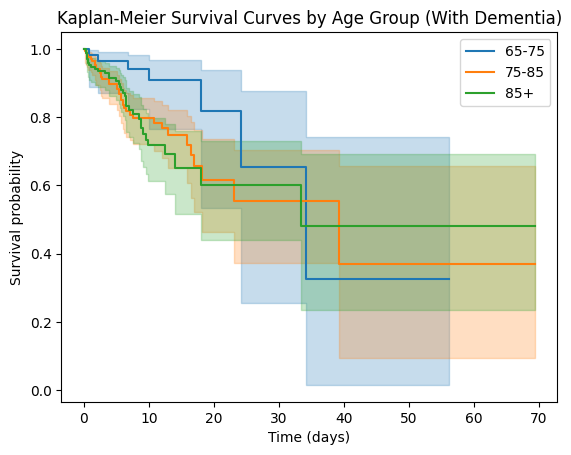

In [54]:
categories = {
    "65-75": (65, 75),
    "75-85": (75, 85),
    "85+": (85, float('inf'))
}

data = dementia

data = data[data['Dementia'] == 1]

import matplotlib.pyplot as plt

for category, (lower_bound, upper_bound) in categories.items():
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]
    
    kmf.fit(durations=category_data['length_of_stay'], event_observed=category_data['HOSPITAL_EXPIRE_FLAG'], label=category)
    
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Age Group (With Dementia)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.show()


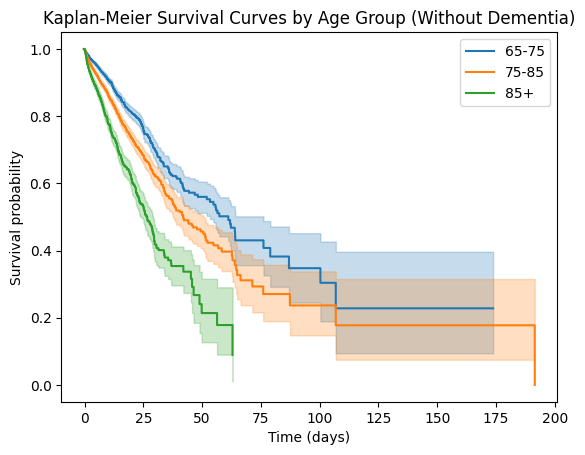

In [55]:
categories = {
    "65-75": (65, 75),
    "75-85": (75, 85),
    "85+": (85, float('inf'))
}

data = dementia

data = data[data['Dementia'] == 0]

import matplotlib.pyplot as plt

for category, (lower_bound, upper_bound) in categories.items():
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]
    
    kmf.fit(durations=category_data['length_of_stay'], event_observed=category_data['HOSPITAL_EXPIRE_FLAG'], label=category)
    
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Age Group (Without Dementia)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.show()


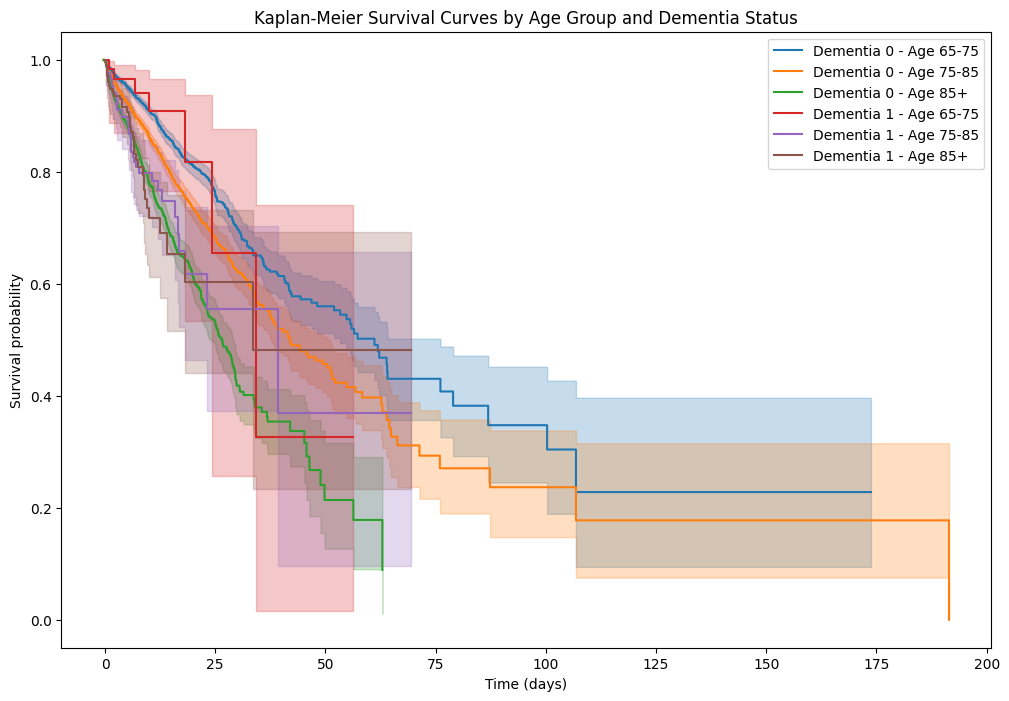

In [7]:
categories = {
    "65-75": (65, 75),
    "75-85": (75, 85),
    "85+": (85, float('inf'))
}

kmf = KaplanMeierFitter()

plt.figure(figsize=(12, 8))

data = dementia

for dementia_status in [0, 1]:
    dementia_data = data[data['Dementia'] == dementia_status]

    for category, (lower_bound, upper_bound) in categories.items():
        category_data = dementia_data[(dementia_data['AGE'] >= lower_bound) & (dementia_data['AGE'] <= upper_bound)]
        
        kmf.fit(durations=category_data['length_of_stay'], event_observed=category_data['HOSPITAL_EXPIRE_FLAG'], label=f'Dementia {dementia_status} - Age {category}')
        
        kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Age Group and Dementia Status')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.legend()

plt.show()


In [10]:
data = dementia[dementia['Dementia'] == 1]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu'] 
    print(f"Age Group {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Length of Stay: 8.5 days
  - Variability (Std. Dev. of log-length): 0.11

Age Group Age 75-85:
  - Median Length of Stay: 8.1 days
  - Variability (Std. Dev. of log-length): 0.06

Age Group Age 85+:
  - Median Length of Stay: 6.8 days
  - Variability (Std. Dev. of log-length): 0.06



In [11]:
data = dementia[dementia['Dementia'] == 1]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]

age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.8805738326181363, but should be close to 0.8. Try to increase the number of tuning steps.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Length of Stay: 8.5 days
  - Variability (Std. Dev. of log-length): 0.73

Age Group Age 75-85:
  - Median Length of Stay: 4.1 days
  - Variability (Std. Dev. of log-length): 0.20

Age Group Age 85+:
  - Median Length of Stay: 3.6 days
  - Variability (Std. Dev. of log-length): 0.22



In [12]:
data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
data = data[data['length_of_stay'] > 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            mean_log = np.log(data['length_of_stay'].mean())
            start = {'mu': mean_log, 'sigma': 1.0}
            trace = pm.sample(500, start=start, tune=1000)


            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/3042956274.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/3042956274.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 34 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/3042956274.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Length of Stay: 8.2 days
  - Variability (Std. Dev. of log-length): 0.01

Age Group Age 75-85:
  - Median Length of Stay: 8.2 days
  - Variability (Std. Dev. of log-length): 0.01

Age Group Age 85+:
  - Median Length of Stay: 7.4 days
  - Variability (Std. Dev. of log-length): 0.01



In [13]:
data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]
data = data[data['length_of_stay'] > 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            mean_log = np.log(data['length_of_stay'].mean())
            start = {'mu': mean_log, 'sigma': 1.0}
            trace = pm.sample(500, start=start, tune=1000)


            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/1376799253.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 34 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/1376799253.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 33 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_33421/1376799253.py:34: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 33 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Length of Stay: 6.0 days
  - Variability (Std. Dev. of log-length): 0.05

Age Group Age 75-85:
  - Median Length of Stay: 5.2 days
  - Variability (Std. Dev. of log-length): 0.04

Age Group Age 85+:
  - Median Length of Stay: 4.4 days
  - Variability (Std. Dev. of log-length): 0.05



In [14]:
print(dementia["disease_burden"].min())
print(dementia["disease_burden"].quantile(0.25))
print(dementia["disease_burden"].quantile(0.75))
print(dementia["disease_burden"].max())

1
8.0
13.0
39


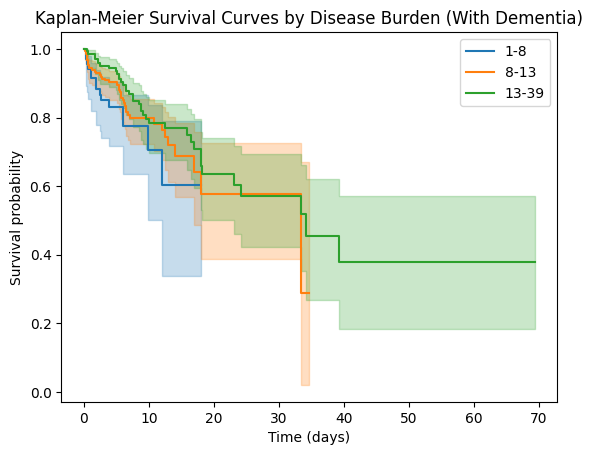

In [56]:
categories = {
    "1-8": (1, 8),
    "8-13": (8, 13),
    "13-39": (13, 38)
}

data = dementia

data = data[data['Dementia'] == 1]

for category, (lower_bound, upper_bound) in categories.items():
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]
    
    kmf.fit(durations=category_data['length_of_stay'], event_observed=category_data['HOSPITAL_EXPIRE_FLAG'], label=category)
    
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Disease Burden (With Dementia)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.show()


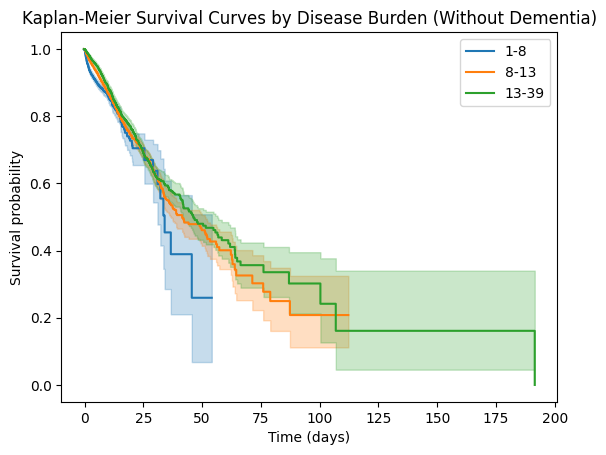

In [57]:
categories = {
    "1-8": (1, 8),
    "8-13": (8, 13),
    "13-39": (13, 38)
}

data = dementia

data = data[data['Dementia'] == 0]

for category, (lower_bound, upper_bound) in categories.items():
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]
    
    kmf.fit(durations=category_data['length_of_stay'], event_observed=category_data['HOSPITAL_EXPIRE_FLAG'], label=category)
    
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Disease Burden (Without Dementia)')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.show()


In [28]:
data = dementia[dementia['Dementia'] == 1]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

results = {}
summaries = {}

for disease_burden in disease_burdens:
    lower_bound, upper_bound = disease_burden
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Disease Burden {lower_bound}-{upper_bound}'] = trace

            summary = pm.summary(trace)
            summaries[f'Disease Burden {lower_bound}-{upper_bound}'] = summary

print("With Dementia and Released from Hospital")
print("Simplified Summary of Hospital Stay by Disease Burden\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Disease Burden {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


With Dementia and Released from Hospital
Simplified Summary of Hospital Stay by Disease Burden

Disease Burden Disease Burden 1-8:
  - Median Length of Stay: 5.3 days
  - Variability (Std. Dev. of log-length): 0.09

Disease Burden Disease Burden 8-13:
  - Median Length of Stay: 6.5 days
  - Variability (Std. Dev. of log-length): 0.05

Disease Burden Disease Burden 13-39:
  - Median Length of Stay: 10.9 days
  - Variability (Std. Dev. of log-length): 0.07



In [29]:
data = dementia[dementia['Dementia'] == 1]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]

disease_burdens = [(1, 8), (8, 13), (13, 39)]

results = {}
summaries = {}

for disease_burden in disease_burdens:
    lower_bound, upper_bound = disease_burden
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Disease Burden {lower_bound}-{upper_bound}'] = trace

            summary = pm.summary(trace)
            summaries[f'Disease Burden {lower_bound}-{upper_bound}'] = summary

print("With Dementia and Died in Hospital")
print("Simplified Summary of Hospital Stay by Disease Burden\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Disease Burden {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


With Dementia and Died in Hospital
Simplified Summary of Hospital Stay by Disease Burden

Disease Burden Disease Burden 1-8:
  - Median Length of Stay: 1.9 days
  - Variability (Std. Dev. of log-length): 0.34

Disease Burden Disease Burden 8-13:
  - Median Length of Stay: 2.9 days
  - Variability (Std. Dev. of log-length): 0.21

Disease Burden Disease Burden 13-39:
  - Median Length of Stay: 7.3 days
  - Variability (Std. Dev. of log-length): 0.18



In [30]:
data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
data = data[data['length_of_stay'] > 0]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

results = {}
summaries = {}

for disease_burden in disease_burdens:
    lower_bound, upper_bound = disease_burden
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Disease Burden {lower_bound}-{upper_bound}'] = trace

            summary = pm.summary(trace)
            summaries[f'Disease Burden {lower_bound}-{upper_bound}'] = summary

print("Without Dementia and Released from Hospital")
print("Simplified Summary of Hospital Stay by Disease Burden\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu']) 
    variability = summary['sd']['mu']
    print(f"Disease Burden {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


Without Dementia and Released from Hospital
Simplified Summary of Hospital Stay by Disease Burden

Disease Burden Disease Burden 1-8:
  - Median Length of Stay: 5.7 days
  - Variability (Std. Dev. of log-length): 0.01

Disease Burden Disease Burden 8-13:
  - Median Length of Stay: 8.2 days
  - Variability (Std. Dev. of log-length): 0.01

Disease Burden Disease Burden 13-39:
  - Median Length of Stay: 11.2 days
  - Variability (Std. Dev. of log-length): 0.01



In [27]:
data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]
data = data[data['length_of_stay'] > 0]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

results = {}
summaries = {}

for disease_burden in disease_burdens:
    lower_bound, upper_bound = disease_burden
    category_data = data[(data['disease_burden'] >= lower_bound) & (data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            trace = pm.sample(1000, return_inferencedata=False)

            results[f'Disease Burden {lower_bound}-{upper_bound}'] = trace

            summary = pm.summary(trace)
            summaries[f'Disease Burden {lower_bound}-{upper_bound}'] = summary

print("Without Dementia and Died in Hospital")
print("Simplified Summary of Hospital Stay by Disease Burden\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Disease Burden {age_group}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


Without Dementia and Died in Hospital
Simplified Summary of Hospital Stay by Disease Burden

Disease Burden Disease Burden 1-8:
  - Median Length of Stay: 2.0 days
  - Variability (Std. Dev. of log-length): 0.06

Disease Burden Disease Burden 8-13:
  - Median Length of Stay: 5.5 days
  - Variability (Std. Dev. of log-length): 0.04

Disease Burden Disease Burden 13-39:
  - Median Length of Stay: 8.8 days
  - Variability (Std. Dev. of log-length): 0.04



In [22]:
age_categories = [(65, 75), (75, 85), (85, float('inf'))]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

data = dementia[(dementia['Dementia'] == 1) & (dementia['HOSPITAL_EXPIRE_FLAG'] == 0)]

results = {}
summaries = {}

for age_category in age_categories:
    age_lower, age_upper = age_category
    age_data = data[(data['AGE'] >= age_lower) & (data['AGE'] <= age_upper)]
    
    for disease_burden in disease_burdens:
        lower_bound, upper_bound = disease_burden
        category_data = age_data[(age_data['disease_burden'] >= lower_bound) & (age_data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()
        
        if len(category_data) > 0:
            with pm.Model() as model:
                mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
                sigma = pm.HalfNormal('sigma', sd=10)

                Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

                trace = pm.sample(1000, return_inferencedata=False, progressbar = False)

                key = f'Age {age_lower}-{age_upper} Disease Burden {lower_bound}-{upper_bound}'
                results[key] = trace

                summary = pm.summary(trace)
                summaries[key] = summary

print("With Dementia and Released from Hospital")
print("Simplified Summary of Hospital Stay by Age and Disease Burden\n")
for key, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"{key}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8822489521498496, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing 

With Dementia and Released from Hospital
Simplified Summary of Hospital Stay by Age and Disease Burden

Age 65-75 Disease Burden 1-8:
  - Median Length of Stay: 4.3 days
  - Variability (Std. Dev. of log-length): 0.35

Age 65-75 Disease Burden 8-13:
  - Median Length of Stay: 8.0 days
  - Variability (Std. Dev. of log-length): 0.12

Age 65-75 Disease Burden 13-39:
  - Median Length of Stay: 12.6 days
  - Variability (Std. Dev. of log-length): 0.18

Age 75-85 Disease Burden 1-8:
  - Median Length of Stay: 5.7 days
  - Variability (Std. Dev. of log-length): 0.13

Age 75-85 Disease Burden 8-13:
  - Median Length of Stay: 6.9 days
  - Variability (Std. Dev. of log-length): 0.08

Age 75-85 Disease Burden 13-39:
  - Median Length of Stay: 11.2 days
  - Variability (Std. Dev. of log-length): 0.10

Age 85-inf Disease Burden 1-8:
  - Median Length of Stay: 5.1 days
  - Variability (Std. Dev. of log-length): 0.15

Age 85-inf Disease Burden 8-13:
  - Median Length of Stay: 5.9 days
  - Variabilit

In [23]:
age_categories = [(65, 75), (75, 85), (85, float('inf'))]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

data = dementia[(dementia['Dementia'] == 1) & (dementia['HOSPITAL_EXPIRE_FLAG'] == 1)]

results = {}
summaries = {}

for age_category in age_categories:
    age_lower, age_upper = age_category
    age_data = data[(data['AGE'] >= age_lower) & (data['AGE'] <= age_upper)]
    
    for disease_burden in disease_burdens:
        lower_bound, upper_bound = disease_burden
        category_data = age_data[(age_data['disease_burden'] >= lower_bound) & (age_data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()
        
        if len(category_data) > 0:
            with pm.Model() as model:
                mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
                sigma = pm.HalfNormal('sigma', sd=10)

                Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

                trace = pm.sample(1000, tune=2000, return_inferencedata=False, progressbar = False)

                key = f'Age {age_lower}-{age_upper} Disease Burden {lower_bound}-{upper_bound}'
                results[key] = trace

                summary = pm.summary(trace)
                summaries[key] = summary

print("With Dementia and Died In Hospital")
print("Simplified Summary of Hospital Stay by Age and Disease Burden\n")
for key, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu']) 
    variability = summary['sd']['mu']
    print(f"{key}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 34 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7201971423926515, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6575960939103467, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUT

With Dementia and Died In Hospital
Simplified Summary of Hospital Stay by Age and Disease Burden

Age 65-75 Disease Burden 8-13:
  - Median Length of Stay: 7.4 days
  - Variability (Std. Dev. of log-length): 2.59

Age 65-75 Disease Burden 13-39:
  - Median Length of Stay: 14.1 days
  - Variability (Std. Dev. of log-length): 0.84

Age 75-85 Disease Burden 1-8:
  - Median Length of Stay: 2.3 days
  - Variability (Std. Dev. of log-length): 0.40

Age 75-85 Disease Burden 8-13:
  - Median Length of Stay: 3.1 days
  - Variability (Std. Dev. of log-length): 0.28

Age 75-85 Disease Burden 13-39:
  - Median Length of Stay: 7.4 days
  - Variability (Std. Dev. of log-length): 0.35

Age 85-inf Disease Burden 1-8:
  - Median Length of Stay: 1.0 days
  - Variability (Std. Dev. of log-length): 1.08

Age 85-inf Disease Burden 8-13:
  - Median Length of Stay: 2.4 days
  - Variability (Std. Dev. of log-length): 0.36

Age 85-inf Disease Burden 13-39:
  - Median Length of Stay: 6.2 days
  - Variability (S

In [24]:
age_categories = [(65, 75), (75, 85), (85, float('inf'))]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
data = data[data['length_of_stay'] > 0]

results = {}
summaries = {}

for age_category in age_categories:
    age_lower, age_upper = age_category
    age_data = data[(data['AGE'] >= age_lower) & (data['AGE'] <= age_upper)]
    
    for disease_burden in disease_burdens:
        lower_bound, upper_bound = disease_burden
        category_data = age_data[(age_data['disease_burden'] >= lower_bound) & (age_data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()
        
        if len(category_data) > 0:
            with pm.Model() as model:
                mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
                sigma = pm.HalfNormal('sigma', sd=10)

                Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

                trace = pm.sample(1000, tune=2000, return_inferencedata=False, progressbar = False)

                key = f'Age {age_lower}-{age_upper} Disease Burden {lower_bound}-{upper_bound}'
                results[key] = trace

                summary = pm.summary(trace)
                summaries[key] = summary

print("Without Dementia and Released from Hospital")
print("Simplified Summary of Hospital Stay by Age and Disease Burden\n")
for key, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"{key}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initi

Without Dementia and Released from Hospital
Simplified Summary of Hospital Stay by Age and Disease Burden

Age 65-75 Disease Burden 1-8:
  - Median Length of Stay: 5.7 days
  - Variability (Std. Dev. of log-length): 0.01

Age 65-75 Disease Burden 8-13:
  - Median Length of Stay: 8.5 days
  - Variability (Std. Dev. of log-length): 0.01

Age 65-75 Disease Burden 13-39:
  - Median Length of Stay: 12.1 days
  - Variability (Std. Dev. of log-length): 0.02

Age 75-85 Disease Burden 1-8:
  - Median Length of Stay: 5.8 days
  - Variability (Std. Dev. of log-length): 0.02

Age 75-85 Disease Burden 8-13:
  - Median Length of Stay: 8.3 days
  - Variability (Std. Dev. of log-length): 0.01

Age 75-85 Disease Burden 13-39:
  - Median Length of Stay: 11.2 days
  - Variability (Std. Dev. of log-length): 0.02

Age 85-inf Disease Burden 1-8:
  - Median Length of Stay: 5.3 days
  - Variability (Std. Dev. of log-length): 0.03

Age 85-inf Disease Burden 8-13:
  - Median Length of Stay: 7.3 days
  - Variabi

In [25]:
age_categories = [(65, 75), (75, 85), (85, float('inf'))]
disease_burdens = [(1, 8), (8, 13), (13, 39)]

data = dementia[dementia['Dementia'] == 0]
data = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]
data = data[data['length_of_stay'] > 0]

results = {}
summaries = {}

for age_category in age_categories:
    age_lower, age_upper = age_category
    age_data = data[(data['AGE'] >= age_lower) & (data['AGE'] <= age_upper)]
    
    for disease_burden in disease_burdens:
        lower_bound, upper_bound = disease_burden
        category_data = age_data[(age_data['disease_burden'] >= lower_bound) & (age_data['disease_burden'] <= upper_bound)]['length_of_stay'].dropna()
        
        if len(category_data) > 0:
            with pm.Model() as model:
                mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
                sigma = pm.HalfNormal('sigma', sd=10)

                Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

                trace = pm.sample(1000, tune=2000, return_inferencedata=False, progressbar = False)


                # Store trace
                key = f'Age {age_lower}-{age_upper} Disease Burden {lower_bound}-{upper_bound}'
                results[key] = trace

                # Summarize the results
                summary = pm.summary(trace)
                summaries[key] = summary

print("Without Dementia and Died In Hospital")
print("Simplified Summary of Hospital Stay by Age and Disease Burden\n")
for key, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"{key}:")
    print(f"  - Median Length of Stay: {median_los:.1f} days")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 30 seconds.
Auto-assigning NUTS sampler...
Initi

Without Dementia and Died In Hospital
Simplified Summary of Hospital Stay by Age and Disease Burden

Age 65-75 Disease Burden 1-8:
  - Median Length of Stay: 1.9 days
  - Variability (Std. Dev. of log-length): 0.13

Age 65-75 Disease Burden 8-13:
  - Median Length of Stay: 5.9 days
  - Variability (Std. Dev. of log-length): 0.07

Age 65-75 Disease Burden 13-39:
  - Median Length of Stay: 10.6 days
  - Variability (Std. Dev. of log-length): 0.07

Age 75-85 Disease Burden 1-8:
  - Median Length of Stay: 2.0 days
  - Variability (Std. Dev. of log-length): 0.09

Age 75-85 Disease Burden 8-13:
  - Median Length of Stay: 5.6 days
  - Variability (Std. Dev. of log-length): 0.05

Age 75-85 Disease Burden 13-39:
  - Median Length of Stay: 8.6 days
  - Variability (Std. Dev. of log-length): 0.06

Age 85-inf Disease Burden 1-8:
  - Median Length of Stay: 1.8 days
  - Variability (Std. Dev. of log-length): 0.10

Age 85-inf Disease Burden 8-13:
  - Median Length of Stay: 4.8 days
  - Variability (S

In [34]:
selected_columns = ['length_of_stay', 'HOSPITAL_EXPIRE_FLAG', 'AGE', 'disease_burden', 'max_heart_rate', 'min_heart_rate', 'avg_heart_rate']

df_selected = dementia[selected_columns]

df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)

df_selected['AGE_time'] = df_selected['AGE'] * np.log(df_selected['length_of_stay'] + 1)
df_selected['disease_burden_time'] = df_selected['disease_burden'] * np.log(df_selected['length_of_stay'] + 1)

cph = CoxPHFitter()
cph.fit(df_selected, duration_col='length_of_stay', event_col='HOSPITAL_EXPIRE_FLAG')

summary = cph.summary[['coef','exp(coef)','p']]
summary = summary.rename(columns={'coef': 'Coefficient', 'exp(coef)': 'Hazard Ratio', 'p': 'p-value'})
summary

/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2547950538.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2547950538.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2547950538.py:8: SettingWithCopy

,Coefficient,Hazard Ratio,p-value
covariate,,,
AGE,0.019637,1.019831,1.017680e-240
disease_burden,0.402009,1.494825,0.000000e+00
max_heart_rate,0.002451,1.002454,1.161569e-02
min_heart_rate,-0.031436,0.969053,1.384079e-147
avg_heart_rate,0.033628,1.034200,1.716453e-68
AGE_time,-0.010593,0.989463,9.018447e-140
disease_burden_time,-0.174792,0.839631,0.000000e+00


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1354/734212302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1354/734212302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)


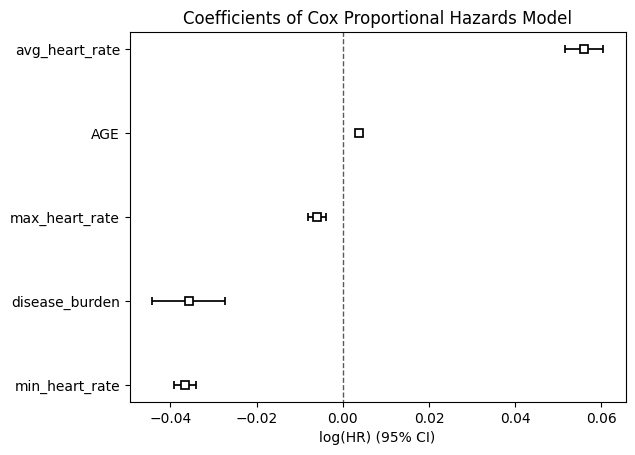

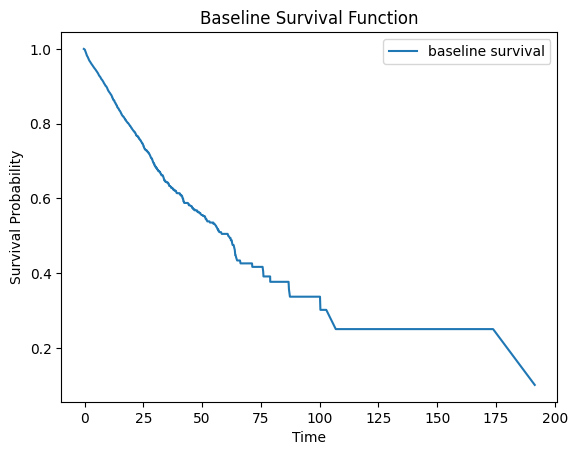

In [26]:
data = dementia[dementia['Dementia'] == 0]
df_selected = data[selected_columns]

df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)

cph = CoxPHFitter()
cph.fit(df_selected, duration_col='length_of_stay', event_col='HOSPITAL_EXPIRE_FLAG')

cph.plot()
plt.title("Coefficients of Cox Proportional Hazards Model")
plt.show()

new_data = df_selected.iloc[:5] 
survival_function = cph.predict_survival_function(new_data)

baseline_survival = cph.baseline_survival_
baseline_survival.plot()
plt.title("Baseline Survival Function")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2047562925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2047562925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)


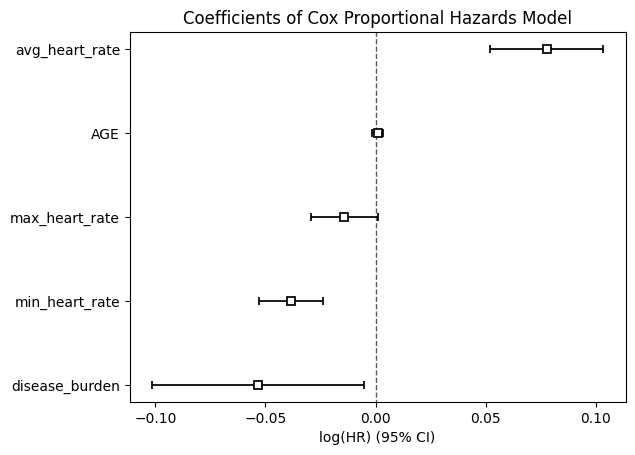

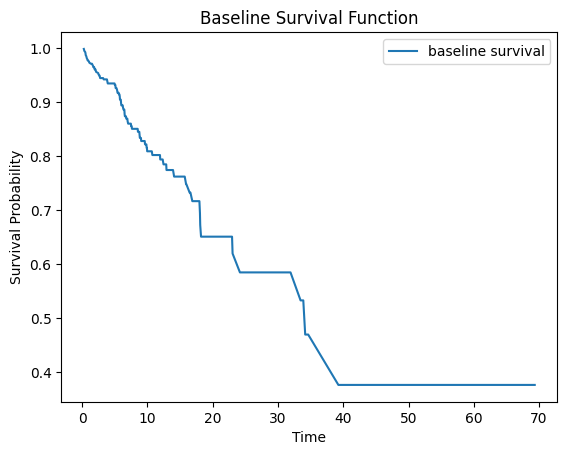

In [37]:
data = dementia[dementia['Dementia'] == 1]
df_selected = data[selected_columns]

df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)

cph = CoxPHFitter()
cph.fit(df_selected, duration_col='length_of_stay', event_col='HOSPITAL_EXPIRE_FLAG')

cph.plot()
plt.title("Coefficients of Cox Proportional Hazards Model")
plt.show()

new_data = df_selected.iloc[:5] 
survival_function = cph.predict_survival_function(new_data)

baseline_survival = cph.baseline_survival_
baseline_survival.plot()
plt.title("Baseline Survival Function")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1354/4239943975.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1354/4239943975.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)


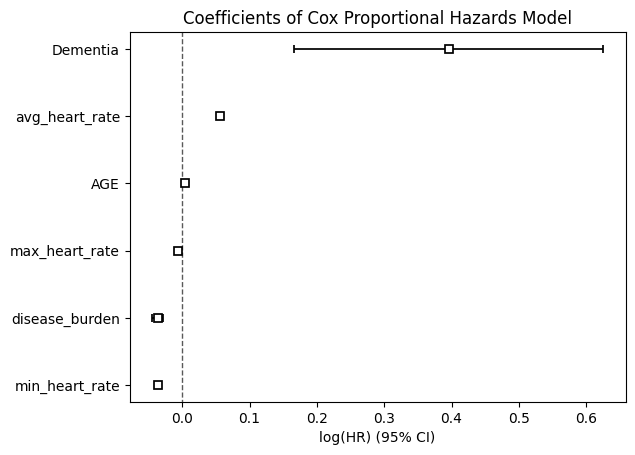

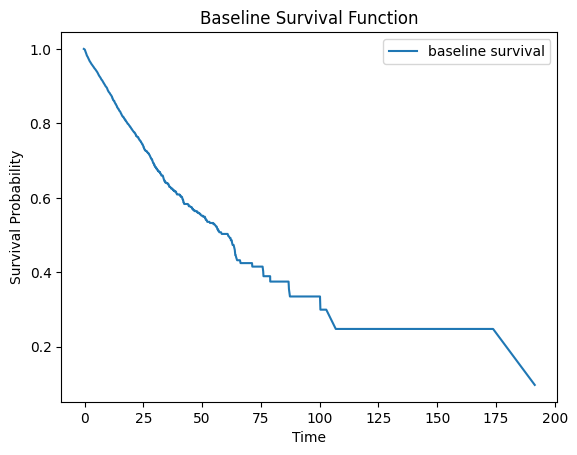

In [36]:
data = dementia[dementia['Dementia'].isin([0, 1])]

selected_columns = ['Dementia','length_of_stay', 'HOSPITAL_EXPIRE_FLAG', 'AGE', 'disease_burden', 'max_heart_rate', 'min_heart_rate', 'avg_heart_rate']

df_selected = data[selected_columns]

df_selected['length_of_stay'] = df_selected['length_of_stay'].astype(float)
df_selected['HOSPITAL_EXPIRE_FLAG'] = df_selected['HOSPITAL_EXPIRE_FLAG'].astype(int)

cph = CoxPHFitter()
cph.fit(df_selected, duration_col='length_of_stay', event_col='HOSPITAL_EXPIRE_FLAG')

cph.plot()
plt.title("Coefficients of Cox Proportional Hazards Model")
plt.show()

new_data = df_selected.iloc[:5] 
survival_function = cph.predict_survival_function(new_data)

baseline_survival = cph.baseline_survival_
baseline_survival.plot()
plt.title("Baseline Survival Function")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.show()

In [10]:
age_bins = [65, 75, 85, np.inf]
age_labels = ['65-75', '75-85', '85+']
dementia['age_group'] = pd.cut(dementia['AGE'], bins=age_bins, labels=age_labels, right=False)

def summarize_group(df, group_name):
    median_length_of_stay = df['length_of_stay'].median()
    median_heart_rate = df['avg_heart_rate'].median()
    variability_length_of_stay = np.log(df['length_of_stay']).std()
    variability_heart_rate = np.log(df['avg_heart_rate']).std()
    
    summary = {
        'Group': group_name,
        'Median Length of Stay': f'{median_length_of_stay:.2f} days',
        'Median Heart Rate': f'{median_heart_rate:.2f} bpm',
        'Variability in Heart Rate': f'{variability_heart_rate:.2f}'
    }
    return summary

summaries = []
for group in age_labels:
    group_df = dementia[dementia['age_group'] == group]
    summary = summarize_group(group_df, group)
    summaries.append(summary)

summary_df = pd.DataFrame(summaries)
summary_df

/Users/john/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Group,Median Length of Stay,Median Heart Rate,Variability in Heart Rate
0,65-75,7.92 days,83.42 bpm,0.16
1,75-85,7.96 days,81.69 bpm,0.16
2,85+,7.04 days,80.50 bpm,0.17


In [19]:
data = dementia[dementia['Dementia'] == 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['max_heart_rate'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            mean_log = np.log(data['max_heart_rate'].mean())
            start = {'mu': mean_log, 'sigma': 1.0}
            trace = pm.sample(500, start=start, tune=1000)


            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Max Heart Rate: {median_los:.1f} bpm")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/3823614236.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/3823614236.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/3823614236.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Max Heart Rate: 109.2 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 75-85:
  - Median Max Heart Rate: 108.6 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 85+:
  - Median Max Heart Rate: 108.0 bpm
  - Variability (Std. Dev. of log-length): 0.01



In [20]:
data = dementia[dementia['Dementia'] == 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['min_heart_rate'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            mean_log = np.log(data['min_heart_rate'].mean())
            start = {'mu': mean_log, 'sigma': 1.0}
            trace = pm.sample(500, start=start, tune=1000)


            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Min Heart Rate: {median_los:.1f} bpm")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/74999084.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/74999084.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/74999084.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Min Heart Rate: 61.5 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 75-85:
  - Median Min Heart Rate: 59.1 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 85+:
  - Median Min Heart Rate: 58.9 bpm
  - Variability (Std. Dev. of log-length): 0.01



In [21]:
data = dementia[dementia['Dementia'] == 0]
age_ranges = [(65, 75), (75, 85), (85, float('inf'))]

results = {}
summaries = {}

for age_range in age_ranges:
    lower_bound, upper_bound = age_range
    category_data = data[(data['AGE'] >= lower_bound) & (data['AGE'] <= upper_bound)]['avg_heart_rate'].dropna()

    if len(category_data) > 0:
        with pm.Model() as model:
            mu = pm.Normal('mu', mu=np.mean(category_data), sd=10)
            sigma = pm.HalfNormal('sigma', sd=10)

            Y_obs = pm.LogNormal('Y_obs', mu=mu, sigma=sigma, observed=category_data)

            mean_log = np.log(data['avg_heart_rate'].mean())
            start = {'mu': mean_log, 'sigma': 1.0}
            trace = pm.sample(500, start=start, tune=1000)


            results[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = trace

            summary = pm.summary(trace)
            summaries[f'Age {lower_bound}-{upper_bound}' if upper_bound != float('inf') else f'Age 85+'] = summary

print("Simplified Summary of Hospital Stay by Age Group\n")
for age_group, summary in summaries.items():
    median_los = np.exp(summary['mean']['mu'])
    variability = summary['sd']['mu']
    print(f"Age Group {age_group}:")
    print(f"  - Median Avg Heart Rate: {median_los:.1f} bpm")
    print(f"  - Variability (Std. Dev. of log-length): {variability:.2f}\n")


/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2787672477.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2787672477.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2787672477.py:20: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(500, start=start, tune=1000)
/Users/john/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 29 seconds.


Simplified Summary of Hospital Stay by Age Group

Age Group Age 65-75:
  - Median Avg Heart Rate: 82.6 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 75-85:
  - Median Avg Heart Rate: 80.9 bpm
  - Variability (Std. Dev. of log-length): 0.00

Age Group Age 85+:
  - Median Avg Heart Rate: 80.6 bpm
  - Variability (Std. Dev. of log-length): 0.00



/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/2878324035.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_combined, x='Age Group', y='Median Length of Stay', hue='Dementia', ci=None)


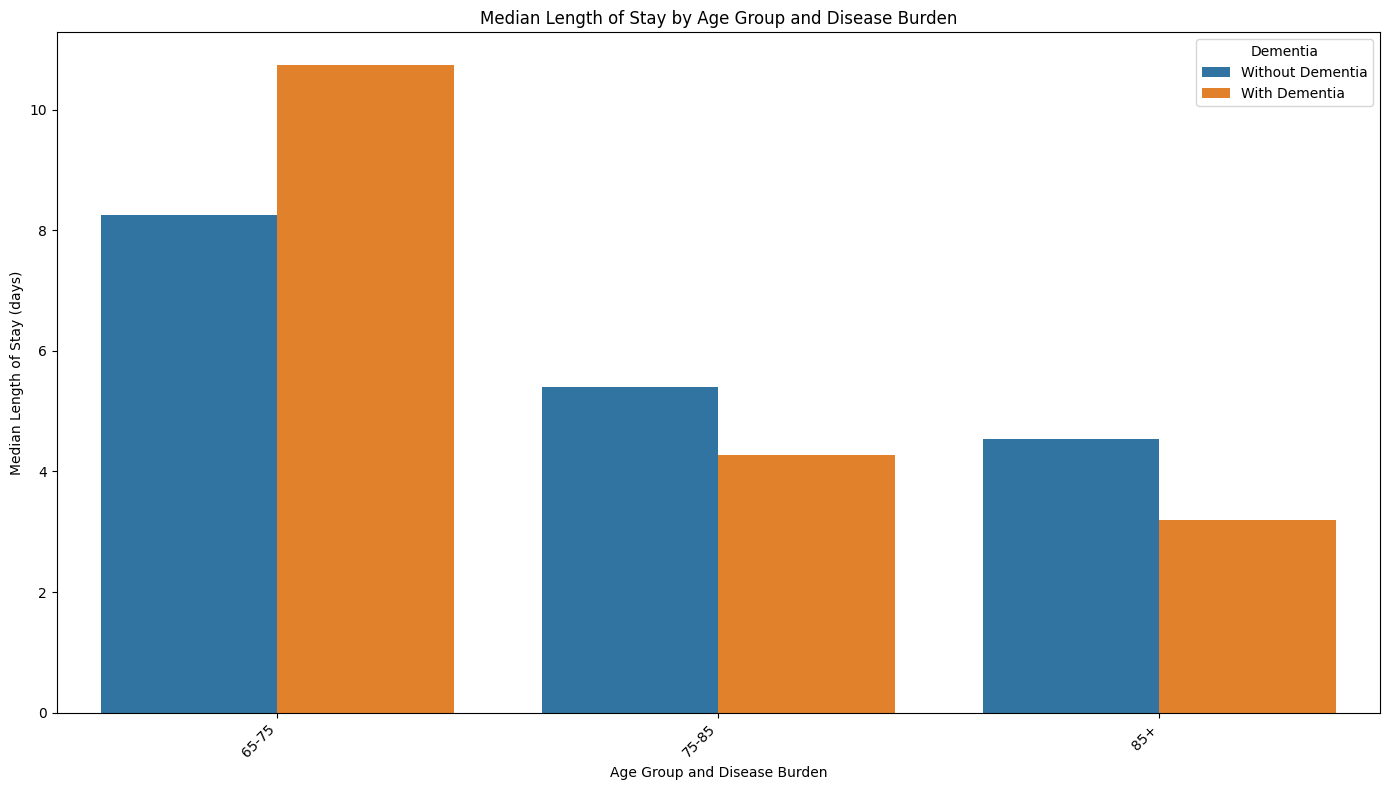

In [46]:
data_without_dementia = {
    'Age Group': ['65-75', '65-75', '75-85', '75-85', '75-85', '85+', '85+', '85+'],
    'Disease Burden': ['8-13', '13-39', '1-8', '8-13', '13-39', '1-8', '8-13', '13-39'],
    'Median Length of Stay': [5.9, 10.6, 2.0, 5.6, 8.6, 1.8, 4.8, 7.0],
    'Variability': [0.07, 0.07, 0.09, 0.05, 0.06, 0.10, 0.07, 0.08]
}

data_with_dementia = {
    'Age Group': ['65-75', '65-75', '75-85', '75-85', '75-85', '85+', '85+', '85+'],
    'Disease Burden': ['8-13', '13-39', '1-8', '8-13', '13-39', '1-8', '8-13', '13-39'],
    'Median Length of Stay': [7.4, 14.1, 2.3, 3.1, 7.4, 1.0, 2.4, 6.2],
    'Variability': [2.59, 0.84, 0.40, 0.28, 0.35, 1.08, 0.36, 0.24]
}

df_without_dementia = pd.DataFrame(data_without_dementia)
df_with_dementia = pd.DataFrame(data_with_dementia)

df_without_dementia['Dementia'] = 'Without Dementia'
df_with_dementia['Dementia'] = 'With Dementia'

df_combined = pd.concat([df_without_dementia, df_with_dementia])

plt.figure(figsize=(14, 8))
sns.barplot(data=df_combined, x='Age Group', y='Median Length of Stay', hue='Dementia', ci=None)

plt.title('Median Length of Stay by Age Group and Disease Burden')
plt.xlabel('Age Group and Disease Burden')
plt.ylabel('Median Length of Stay (days)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dementia')
plt.tight_layout()
plt.show()

/var/folders/k3/xxbhgyps3xn8nw06qdqxd3sh0000gn/T/ipykernel_1358/427268722.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_combined, x='Age Group', y='Median Length of Stay', hue='Dementia', ci=None)


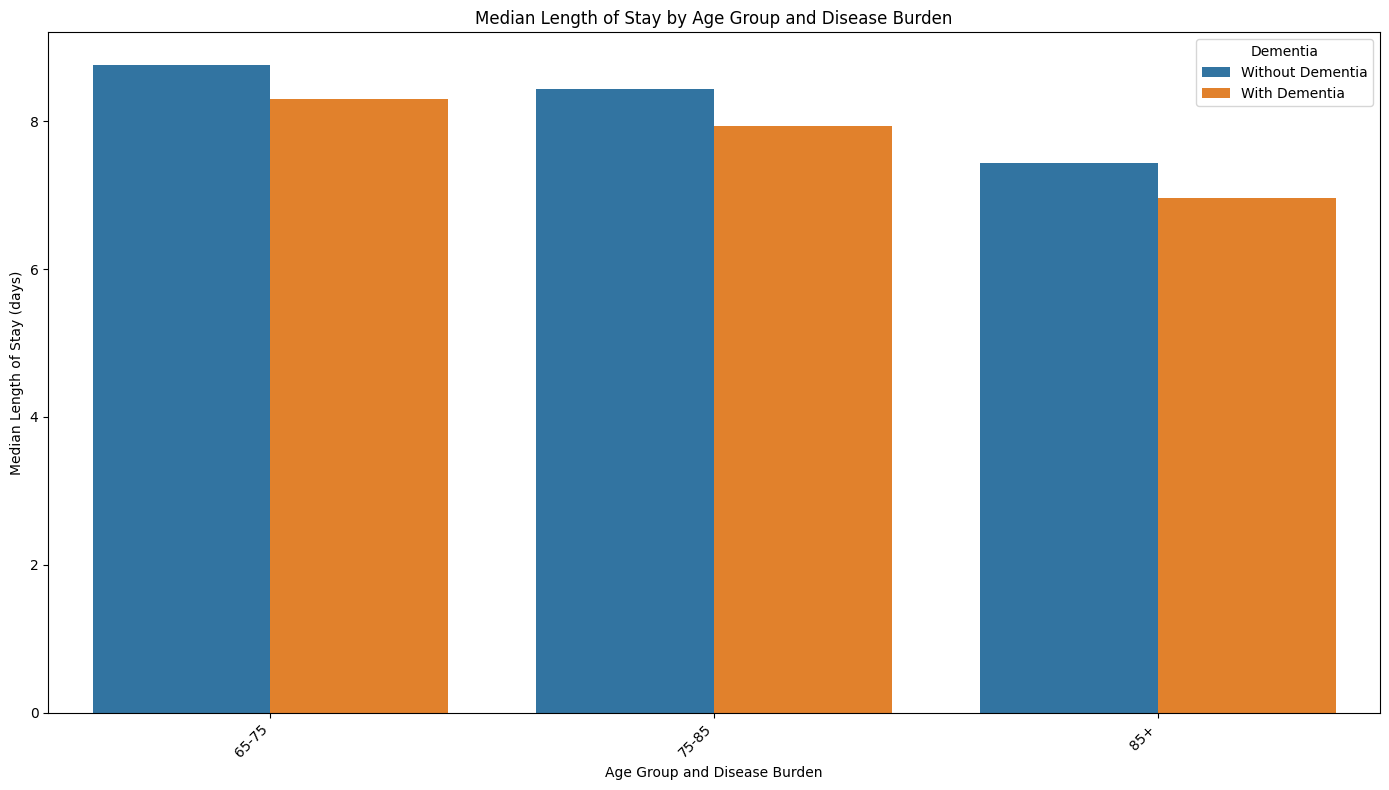

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the images
data_without_dementia = {
    'Age Group': ['65-75', '65-75', '65-75', '75-85', '75-85', '75-85', '85+', '85+', '85+'],
    'Disease Burden': ['1-8', '8-13', '13-39', '1-8', '8-13', '13-39', '1-8', '8-13', '13-39'],
    'Median Length of Stay': [5.7, 8.5, 12.1, 5.8, 8.3, 11.2, 5.3, 7.3, 9.7],
    'Variability': [0.01, 0.01, 0.02, 0.02, 0.01, 0.02, 0.02, 0.02, 0.03]
}

data_with_dementia = {
    'Age Group': ['65-75', '65-75', '65-75', '75-85', '75-85', '75-85', '85+', '85+', '85+'],
    'Disease Burden': ['1-8', '8-13', '13-39', '1-8', '8-13', '13-39', '1-8', '8-13', '13-39'],
    'Median Length of Stay': [4.3, 8.0, 12.6, 5.7, 6.9, 11.2, 5.1, 5.9, 9.9],
    'Variability': [0.35, 0.12, 0.18, 0.13, 0.08, 0.10, 0.15, 0.08, 0.11]
}

df_without_dementia = pd.DataFrame(data_without_dementia)
df_with_dementia = pd.DataFrame(data_with_dementia)

df_without_dementia['Dementia'] = 'Without Dementia'
df_with_dementia['Dementia'] = 'With Dementia'

df_combined = pd.concat([df_without_dementia, df_with_dementia])

plt.figure(figsize=(14, 8))
sns.barplot(data=df_combined, x='Age Group', y='Median Length of Stay', hue='Dementia', ci=None)

plt.title('Median Length of Stay by Age Group and Disease Burden')
plt.xlabel('Age Group and Disease Burden')
plt.ylabel('Median Length of Stay (days)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dementia')
plt.tight_layout()
plt.show()
